# LSTM 계층 구현 

In [1]:
# 스타벅스 주가 데이터
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv(r'.\data/SBUX.csv')
print(data.dtypes)
print(data)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
           Date        Open        High         Low       Close   Adj Close  \
0    2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752   
1    2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032   
2    2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046   
3    2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941   
4    2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288   
..          ...         ...         ...         ...         ...         ...   
248  2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787   
249  2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918   
250  2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554   
251  2020-12-09  101.940002  102.209999  100.0999

In [2]:
import torch
import numpy as np
import random

def seed_everything(seed=4):
    random.seed(seed)  # Python 난수 고정
    np.random.seed(seed)  # NumPy 난수 고정
    torch.manual_seed(seed)  # PyTorch 난수 고정
    torch.cuda.manual_seed(seed)  # CUDA 연산 시드 고정
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경 시드 고정
    torch.backends.cudnn.deterministic = True  # CUDA 연산 결정적으로 수행
    torch.backends.cudnn.benchmark = False  # 성능 최적화 비활성화

seed_everything(4)  # 시드 설정 실행

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

In [4]:
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [5]:
# 스케일러 적용
ms = MinMaxScaler() #0~1
ss = StandardScaler() # 평균 0, 표준편차 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (200, 5) (200, 1)
Testing Shape : (53, 5) (53, 1)


In [6]:
# 데이터셋 형태, 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape :', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape : torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape : torch.Size([53, 1, 5]) torch.Size([53, 1])


In [7]:
#네트워크 정의
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init__()

        #하이퍼 파라미터 
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        # LSTM 레이어 정의
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)
        #Fully connected 레이어 정의
        self.fc_1 = nn.Linear(hidden_size, 128) 
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x) :

        # hidden state & cell state 설정
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # LSTM 순전파 
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        #hidden state의 마지막 레이어 사용
        hn = hn.view(-1, self.hidden_size)
        
        # 활성화 함수 & FC layer 통과
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

- Loss Function의 역할

  모델이 얼마나 잘 학습하고 있는지를 수치적으로 나타내는 지표.
  
  예측 값과 실제 정답 간의 차이를 계산하여, 최적의 모델 파라미터를 찾도록 도와주는 역할.
- 필요한 이유
1. 모델 평가: 예측값이 실제 값과 얼마나 차이가 나는지 수치적 평가 가능.
2. Gradient Descent 사용 가능: loss 값을 줄이도록 모델의 weight를 업데이트 하는데 사용됨.
3. 최적화 방향 제공: 손실 함수의 gradient를 계산하여, 학습이 진행될 방향 결정할 수 있음.

In [8]:
def custom_mse(outputs, targets):
    return torch.sum((outputs - targets)**2) / targets.numel() # numel -> 전체 원소 개수

loss_functions = {
    'Custom MSE': custom_mse, 
    'MSE': nn.MSELoss(), # Regression 문제에서 가장 기본적인 loss function
    'MAE': nn.L1Loss(), # Outlier에 강한 Regression
    'Huber': nn.SmoothL1Loss(), # 노이즈가 있는 Regression에 적합
    'Hinge': nn.HingeEmbeddingLoss(), # Binary Classification 문제
    'CrossEntropy': nn.CrossEntropyLoss() #Multi-class Classification 문제
}

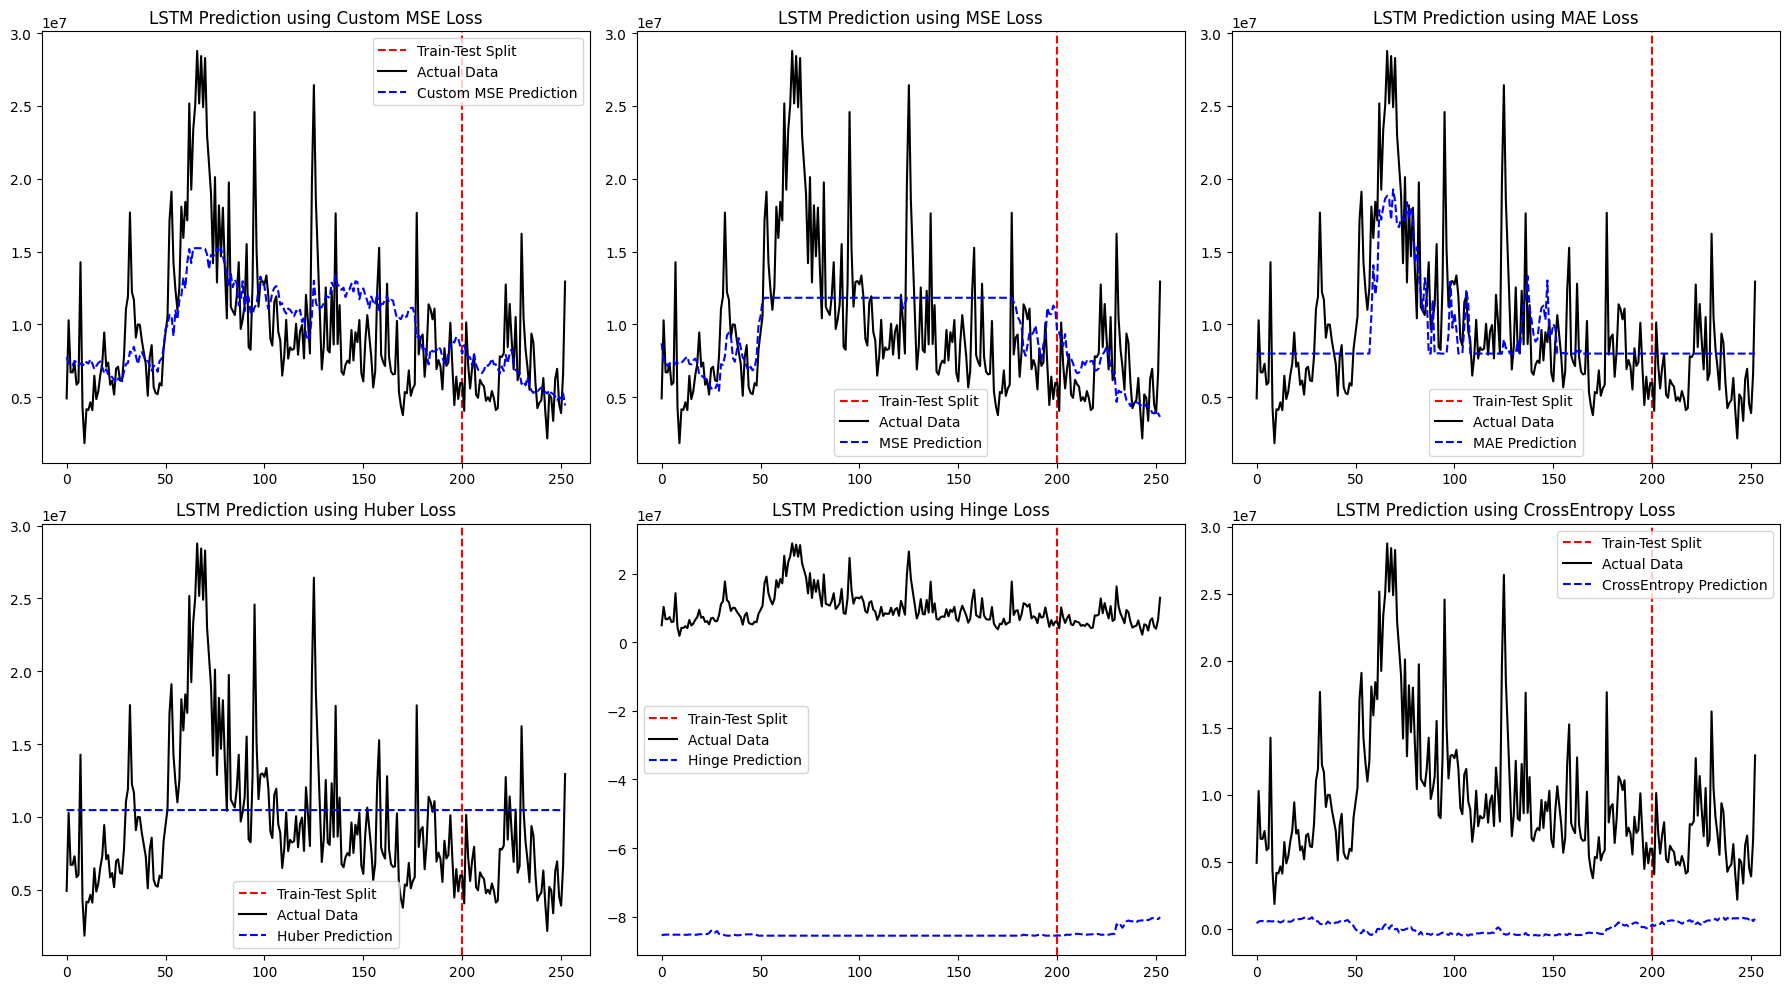

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

def train_and_plot(criterion_name, criterion, ax):
    model = LSTM(1, 5, 2, 1, X_train_tensors_f.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(1000):
        outputs = model(X_train_tensors_f)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train_tensors)
        loss.backward()
        optimizer.step()
    
    df_x_ss = Variable(torch.Tensor(ss.transform(data.iloc[:, :-1])))
    df_y_ms = Variable(torch.Tensor(ms.transform(data.iloc[:, -1:])))
    df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))
    train_predict = model(df_x_ss).data.numpy()
    label_y = df_y_ms.data.numpy()
    train_predict = ms.inverse_transform(train_predict)
    label_y = ms.inverse_transform(label_y)
    
    ax.axvline(x=200, c='r', linestyle='--', label='Train-Test Split')
    ax.plot(label_y, label='Actual Data', color='black')
    ax.plot(train_predict, label=f'{criterion_name} Prediction', linestyle='dashed', color='blue')
    ax.set_title(f'LSTM Prediction using {criterion_name} Loss')
    ax.legend()

for i, (name, loss_fn) in enumerate(loss_functions.items()):
    train_and_plot(name, loss_fn, axes[i])

plt.tight_layout()
plt.show()

In [10]:
outputs = torch.randn(10, requires_grad=True)
targets = torch.randn(10)

mse_loss_fn = nn.MSELoss()
custom_mse = torch.sum((outputs - targets)**2) / targets.numel()

mse_loss = mse_loss_fn(outputs, targets)

print(f"nn.MSELoss(): {mse_loss.item()}")
print(f"Custom MSE: {custom_mse.item()}")
print(f"Difference: {abs(mse_loss.item() - custom_mse.item())}")

nn.MSELoss(): 1.3853046894073486
Custom MSE: 1.3853046894073486
Difference: 0.0


#### Custom MSE와 MSE 값 차이나는 이유

- 손실 함수가 동일하더라도 학습 과정에서 미세한 차이가 누적될 수 있음.
- 손실 값 자제는 같지만, 학습 과정에서 연산 순서, `autograd` 동작 방식, optimizer 업데이트 방식 차이 등이 미세한 차이를 유발할 수 있음.
- pytorch 내부적으로 `nn.MSELoss()`는 `autograd` 최적화를 수행하는데, 직접 정의한 loss 함수는 그렇지 않을 수도 있음.